In [8]:
import os
import pandas as pd
from sklearn.cluster import KMeans
import shutil
import logging
import matplotlib.pyplot as plt

# Clustering

In [ ]:
def load_all_stock_series(directory):
    try:
        stock_series = {}
        for filename in os.listdir(directory):
            if filename.endswith('.parquet'):
                symbol = filename.split('.')[0]
                file_path = os.path.join(directory, filename)
                stock_series[symbol] = pd.read_parquet(file_path)
                logging.info(f"✅ File {filename} successfully loaded.")
        return stock_series
    
    except FileNotFoundError as e:
        logging.error(f"❌ Directory {directory} not found, {e}.")


def extract_multivariate_features(df):
    try:
        features = []
        for col in df.columns:
            series = df[col]
            features.extend([series.mean(), series.std(), series.skew(), series.kurt()])
        return features
    
    except ValueError as e:
        logging.error(f"❌ Something went wrong when extraction feature from {df}, {e}.")
    

def cluster_by_multivariate_features(stock_data_dict, n_clusters=4):
    try:
        keys = list(stock_data_dict.keys())
        features = [extract_multivariate_features(df) for df in stock_data_dict.values()]
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(features)
        return dict(zip(keys, labels))

    except ValueError as e:
        logging.error(f"❌ Something during clustering the time series, {e}.")


def save_stocks_to_cluster_dirs(clusters, data_directory, output_directory):
    try:
        cluster_dirs = {cluster: os.path.join(output_directory, f"cluster_{cluster}") for cluster in set(clusters.values())}
        for path in cluster_dirs.values():
            os.makedirs(path, exist_ok=True)

        for stock, cluster in clusters.items():
            source_file = os.path.join(data_directory, f"{stock}.parquet")
            dest_folder = cluster_dirs[cluster]

            if os.path.exists(source_file):
                shutil.copy(source_file, os.path.join(dest_folder, f"{stock}.parquet"))
            else:
                print(f"Warning: {source_file} not found!")
    
    except FileNotFoundError as e:
        logging.error(f"❌ Directory {data_directory} not found, {e}.")


if __name__ == "__main__":
    directory_path = r"/Users/akramchakrouni/Projects/time-series-forecasting-cluserting/data/chronos"
    stock_data_dict = load_all_stock_series(directory_path)
    clusters = cluster_by_multivariate_features(stock_data_dict, n_clusters=4)

    data_directory = r"/Users/akramchakrouni/Projects/time-series-forecasting-cluserting/data/chronos"
    output_directory = r"/Users/akramchakrouni/Projects/time-series-forecasting-cluserting/clusters/statistical"
    save_stocks_to_cluster_dirs(clusters, data_directory, output_directory)

# Finding ideal amount of clusters

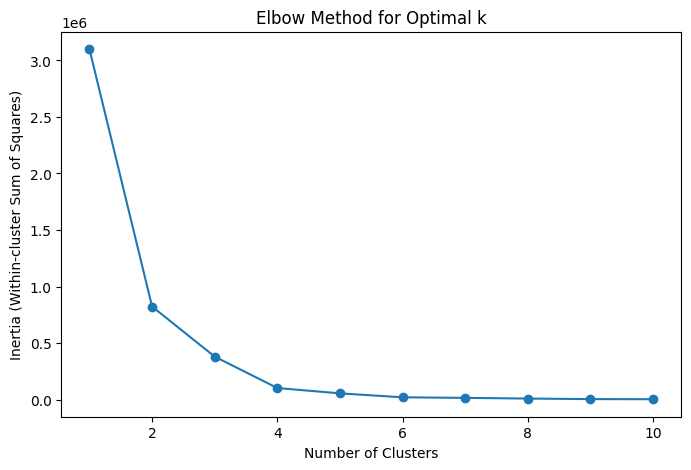

In [ ]:
#----------Elbow Method----------#
# The lower the inertia the better
def find_optimal_clusters(features, max_clusters=10):
    """
    Uses the Elbow Method to find the optimal number of clusters.
    
    Parameters:
    - features: A list of feature vectors, where each vector represents a time series.
    - max_clusters: Maximum number of clusters to test.
    
    Each feature vector should be a list of features (e.g., mean, std, skew, kurtosis) 
    extracted from a single time series.
    """
    try:
        inertia = []
        cluster_range = range(1, max_clusters + 1)

        for k in cluster_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(features)
            inertia.append(kmeans.inertia_)  # Measure of clustering compactness

        plt.figure(figsize=(8, 5))
        plt.plot(cluster_range, inertia, marker='o')
        plt.xlabel("Number of Clusters")
        plt.ylabel("Inertia (Within-cluster Sum of Squares)")
        plt.title("Elbow Method for Optimal k")
        plt.show()

    except Exception as e:
        logging.error(f"❌ Error while finding optimal clusters: {e}")

directory_path = r"/Users/akramchakrouni/Projects/time-series-forecasting-cluserting/data/chronos"
stock_data_dict = load_all_stock_series(directory_path)

features = [extract_multivariate_features(df) for df in stock_data_dict.values()]
find_optimal_clusters(features, max_clusters=10) 

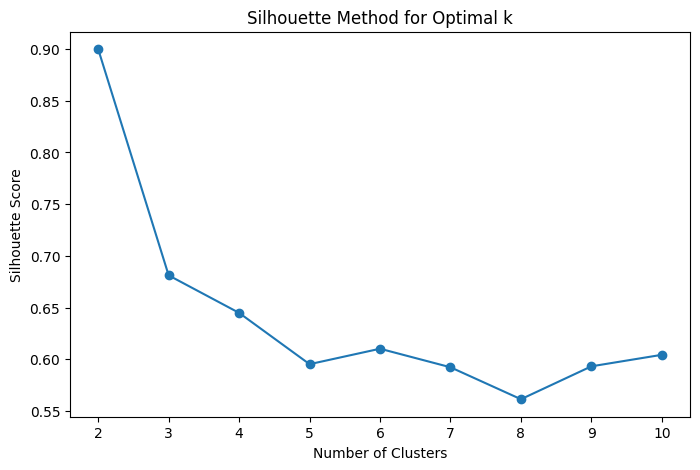

In [ ]:
#----------Silhouette Method----------#
# The higher the better
def find_optimal_clusters_silhouette(features, max_clusters=10):
    """
    Uses the Silhouette Score to find the optimal number of clusters.

    Parameters:
    - features: A list of feature vectors, where each vector represents a time series.
    - max_clusters: Maximum number of clusters to test.

    Each feature vector should be a list of features (e.g., mean, std, skew, kurtosis)
    extracted from a single time series.
    """
    try:
        from sklearn.metrics import silhouette_score
        import matplotlib.pyplot as plt

        silhouette_scores = []
        cluster_range = range(2, max_clusters + 1)  # Silhouette is undefined for k=1

        for k in cluster_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(features)
            score = silhouette_score(features, labels)
            silhouette_scores.append(score)

        # Plot silhouette score vs. number of clusters
        plt.figure(figsize=(8, 5))
        plt.plot(cluster_range, silhouette_scores, marker='o')
        plt.xlabel("Number of Clusters")
        plt.ylabel("Silhouette Score")
        plt.title("Silhouette Method for Optimal k")
        plt.show()

    except Exception as e:
        logging.error(f"❌ Error while finding optimal clusters with Silhouette: {e}")


# Example usage:
directory_path = r"/Users/akramchakrouni/Projects/time-series-forecasting-cluserting/data/chronos"
stock_data_dict = load_all_stock_series(directory_path)

features = [extract_multivariate_features(df) for df in stock_data_dict.values()]
find_optimal_clusters_silhouette(features, max_clusters=10)

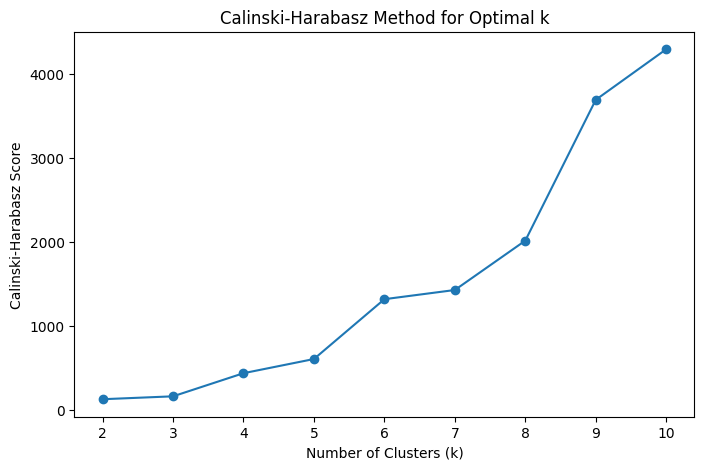

Optimal k based on Calinski-Harabasz Index: 10


In [ ]:
#----------Calinski-Harabasz Method----------#
# The higher the better
def find_optimal_clusters_calinski_harabasz(features, max_clusters=10):
    """
    Uses the Calinski-Harabasz Index to find the optimal number of clusters.

    Parameters:
    - features: A list of feature vectors, where each vector represents a time series.
    - max_clusters: Maximum number of clusters to test.

    Each feature vector should be a list of features (e.g., mean, std, skew, kurtosis)
    extracted from a single time series.

    Returns:
    - scores: A list of Calinski-Harabasz scores for each k
    - best_k: The number of clusters that yields the highest Calinski-Harabasz score
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    from sklearn.metrics import calinski_harabasz_score
    import logging

    try:
        scores = []
        cluster_range = range(2, max_clusters + 1)

        # Loop through each possible cluster count
        for k in cluster_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(features)
            # Calinski-Harabasz score: higher is better
            score = calinski_harabasz_score(features, labels)
            scores.append(score)

        # Identify the best k based on the highest CH score
        best_k = cluster_range[np.argmax(scores)]

        # Plot the scores
        plt.figure(figsize=(8, 5))
        plt.plot(cluster_range, scores, marker='o')
        plt.xlabel("Number of Clusters (k)")
        plt.ylabel("Calinski-Harabasz Score")
        plt.title("Calinski-Harabasz Method for Optimal k")
        plt.show()

        return scores, best_k

    except Exception as e:
        logging.error(f"❌ Error while finding optimal clusters with Calinski-Harabasz: {e}")
        return None, None

# Example usage:
directory_path = r"/Users/akramchakrouni/Projects/time-series-forecasting-cluserting/data/chronos"
stock_data_dict = load_all_stock_series(directory_path)
features = [extract_multivariate_features(df) for df in stock_data_dict.values()]
scores, best_k = find_optimal_clusters_calinski_harabasz(features, max_clusters=10)
print(f"Optimal k based on Calinski-Harabasz Index: {best_k}")
